In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

# Bayesian analysis in Python

Bayesian analysis is one of the main frameworks for conducting statistical inference.  It differs from the *frequentist* framework used elsewhere in this course.  The Bayesian and frequentist approaches to estimation and inference are both rigorous and applicable to a wide array of settings.  In many situations they will give similar conclusions.  The precise mathematical definitions used to accomplish goals such as uncertainty assessment differ between the Bayesian and frequentist settings, and the algorithms used to calculate Bayesian estimates are quite different from those used to calculate frequentist estimates.

In this notebook we illustrate some key concepts from Bayesian analysis.  This notebook will not teach you how to analyze data using Bayesian methods.  There are well-maintained packages including [pystan](https://pystan.readthedocs.io/en/latest) that serve this purpose well.  

## Notation and terminology

We focus on the setting of parameter estimation and uncertainty assessment.  As is typical in most statistical analysis, we have a model that depends on unknown parameters, here denoted $\theta$.  The goal is the use data to estimate $\theta$ and then to assess the precision of this estimate.

$\theta$: a parameter that governs the system being observed, the goal is to learn about $\theta$

$D$: the data that we observe

__Likelihood__ $p(D|\theta)$: the probability of observing the data $D$, for a given value of the parameter $\theta$, calculated using a chosen family of *probability models*

__Prior distribution__ $p(\theta)$: what we know about the value of $\theta$ before seeing data

__Posterior distribution__ $p(\theta|D)$: a result of Bayesian analysis that reflects all that we know about $\theta$ from our data and model

__Evidence__ $p(D)$: the probability of observing the data averaged over all the possible values of the parameter $\theta$

## Bayes' theorem

Most Bayesian analysis is predicated on *Bayes' theorem*, which states that $p(\theta|D) = P(D|\theta)P(\theta)/P(D)$.  That is, the posterior distribution is the likelihood time the prior divided by the evidence.

The evidence $p(D)$ can be considered to be a normalizing constant.  In practice we usually work with the *un-normalized posterior* $p(\theta|D) \propto p(D|\theta) \cdot p(\theta)$.

## Coin - Flipping Problem

We will illustrate these ideas in the context of a coin-flipping experiment.

For a fair coin, the sample space is {_heads_, _tails_}, and each of these outcomes has probability 1/2. 

Now suppose that we have a coin and don't know whether it is fair.  The actual probability of this coin landing heads-up is the parameter $\theta$.

The exact value of $\theta$ can never be known, but we are able to conduct an experiment where we flip this coin $n$ times and observe $x$ heads and $n-x$ tails.  In the notation introduced above, the data $D$ is $(x, n)$.  

The likelihood $p(D|\theta)$ is a single number that captures how well the data match the parameter value $\theta$.

We first discuss the likelihood function, which plays a key role in both frequentist and Bayesian analysis.  We illustrate the likelihood function using the Python function `lf_plot` below.  This function plots the binomial likelihood function for each possible value of the parameter $\theta$, for three given values of $x$, and three different sample sizes $n$.

In [32]:
def lf_plot(n):
    theta = np.linspace(0.01, 0.99, 100)
    for x in np.floor(np.r_[0.2, 0.5, 0.6]*n):
        l = st.binom.pmf(x, n, theta)
        plt.grid(True)
        plt.plot(theta, l, "-", label="%.0f" % x)
        plt.xlabel(r"$\theta$", size=15)
        plt.ylabel("Log likelihood", size=15)
    ha, lb = plt.gca().get_legend_handles_labels()
    plt.figlegend(ha, lb, "center right")

Observing the plots below, we see that the likelihood is higher when the proportion of heads $x/n$ matches the parameter $\theta$.  Also, the likelihood is more concentrated around $x/n$ when the sample size $n$ is larger.  Frequentist statistics generally bases all estimation and inference on the likelihood function alone.  The *maximum likelihood estimate* (MLE) of $\theta$ is the value of $\theta$ that maximizes the likelihood function.  For binomial data as we have here, the MLE is $x/n$.  The concentration of the log-likelihood around the MLE reflects the amount of information in the data about the parameter -- if the likelihood function is more concentrated around the MLE, then the MLE is a more precise estimate of the true value of $\theta$.

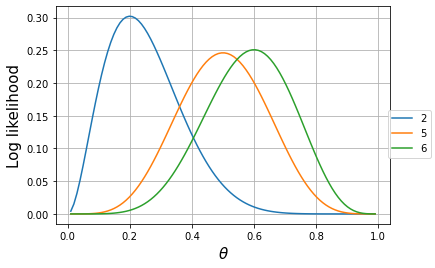

In [33]:
lf_plot(10)

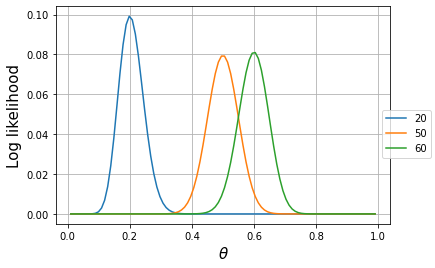

In [34]:
lf_plot(100)

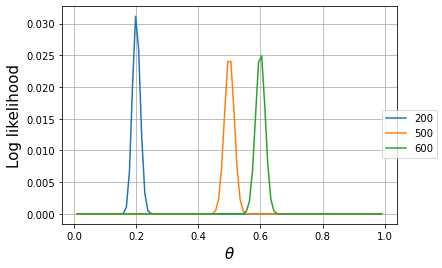

In [35]:
lf_plot(1000)

The posterior distribution in Bayesian statistics combines the information in the likelihood and the prior.  Specifically, the posterior distribution is proportional to the likelihood times the prior.  The prior reflects the knowledge about the parameter that do not come from the data.  

When analyzing data using Bayesian methods, we can choose a prior.  A natural choice for the prior $p(\theta)$ for a binomial model is a uniform distribution on the unit interval $[0, 1]$.  In this case, the prior $p(\theta)$ is identically equal to 1, so the plots above showing likelihood functions also show the posterior distribution $p(\theta|D)$.

### Beta priors

Now suppose we have a strong reason to believe that our coin is fair, and wish to analyze the data in light of this prior knowledge.  To accomplish this, we can use a non-uniform prior that is concentrated around 1/2.  A convenient way to specify a prior for a parameter such as $\theta$, which is a probability that falls between 0 and 1, is to use a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution).  The beta distribution depends on two *shape parameters* $\alpha$ and $\beta$.  Below we graph the density function (pdf) of a beta distribution when $\alpha=\beta=2$.  This particular beta distribution places the greatest prior mass at 1/2, with symmetrically diminishing prior probability for values of $\theta$ close to either 0 or 1.  You can modify the values of $\alpha$ and $\beta$ to see the shape of the prior for other settings of the shape parameters.

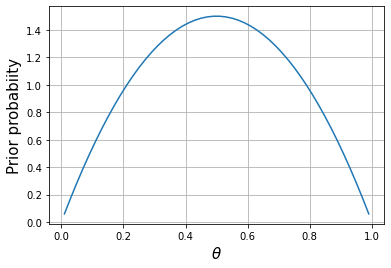

In [36]:
alpha = 2
beta = 2
theta = np.linspace(0.01, 0.99)
plt.grid(True)
plt.plot(theta, st.beta.pdf(theta, alpha, beta))
plt.xlabel(r"$\theta$", size=15)
plt.ylabel("Prior probabiity", size=15);

The function below calculates the posterior distribution (up to a proportionality constant) for a dataset consisting of $x$ heads out of $n$ trials, using a Beta prior distribution with the given values of the shape parameters $\alpha$ and $\beta$. 

In [37]:
def post(x, n, alpha, beta, theta):
    return st.binom.pmf(x, n, theta) * st.beta.pdf(theta, alpha, beta)

The example below illustrates the difference between Bayesian and frequentist inference in this setting.  If we observe $x$ heads out of $n$ tosses of the coin, we can use a Beta prior distribution with the given shape parameters to estimate $\theta$ (the true probability of the coin landing heads-up).

The blue and orange curves depict the posterior distribution for two different priors.  In Bayesian analysis, the posterior distribution reflects all relevant information in the data about the parameter.  Using a relatively flat prior ($\alpha=\beta=1$, orange curve) the posterior distribution has a peak very close to the MLE.  The dispersion of the posterior distribution reflects the precision of this estimate.  If we instead use a more concentrated prior with $\alpha=\beta=10$, the mode of the posterior is shrunk toward the mean of the prior distribution, which is $1/2$.  The posterior is also somewhat more concentrated as we are using a more concentrated prior.

The black horizontal line in the graph is the MLE, which always falls at $x/n$.

Text(0, 0.5, 'Posterior probability\n(not normalized)')

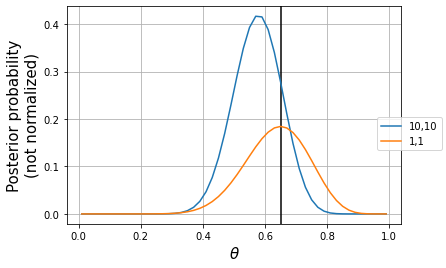

In [38]:
x = 13
n = 20
plt.grid(True)
plt.axvline(x/n, color="black")
alpha, beta = 10, 10
po = post(x, n, 10, 10, theta)
plt.plot(theta, po, label="10,10")
alpha, beta = 1, 1
po = post(x, n, 1, 1, theta)
plt.plot(theta, po, label="1,1")
ha, lb = plt.gca().get_legend_handles_labels()
plt.figlegend(ha, lb, "center right")
plt.xlabel(r"$\theta$", size=15)
plt.ylabel("Posterior probability\n(not normalized)", size=15)